## Klasyfikacja ręcznie pisanych liczb - MNIST

Po wykonaniu poprzedniego zadania zleceniodawca znów zadzwonił do Ciebie z kolejnym zadaniem. Okazuje się, że nie wszystkie informacje trafiły do zbioru Tytanic. Brakowało w nim między innymi informacji o pokojach w których mieszkali pasażerowie. Wszystkie informacje o miejscu spania były bowiem zapisane odręcznie na kartkach. Tajemniczy  więc zlecił Ci nowe zadanie... **Stworzenie konwolucyjnej sieci neuronowej rozpoznającej ręcznie pisane cyfry.**

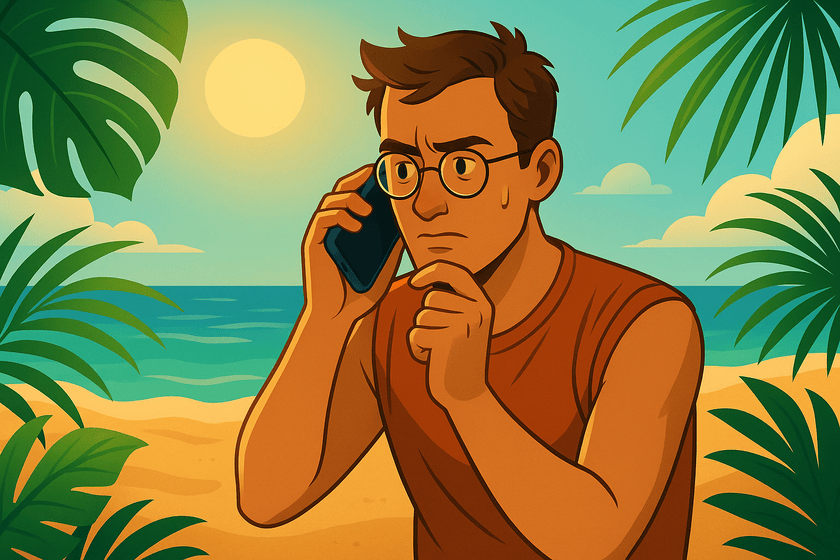

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modelu widzenia komputerowego (CNN) do klasyfikacji każdej ręcznie pisanej liczby z jak najlepszą dokładnością.

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Co mój model robi i w jaki sposób?
- Na czym skupia się mój model?
- Jakie liczby mój model myli? Dlaczego?
- Jak uodpornić mój model?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Spróbuj dobrać strukture sieci (szerokość i wysokość) i sprawdź jaki ma wpływ na dokładność
- Ćwiczenie: zmień liczbę kanałów/warstw, dodaj BatchNorm, spróbuj zwiększyć/zmniejszyć dropout.
- Wypisz wnioski.
- Korzystaj z `PyTorch` (`torch, torchvision`)

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

# Analiza zbioru MNIST

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import time
import random
import copy

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Podczas pobierania danych zamieniam je od razu w tensor, ponieważ PyTorch pracuje na tensorach i standaryzuje w celu szybszego i stabilniejszego uczenia.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1397,), (0.03081,))
])

train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
len(train_ds), len(test_ds)

(60000, 10000)

Sprawdzam jakiego typu są moje dane.

In [ ]:
type(train_ds)

torchvision.datasets.mnist.MNIST

In [ ]:
type(train_ds[0])

tuple

In [ ]:
type(train_ds[0][0]), type(train_ds[0][1])

(torch.Tensor, int)

Wydzielam zbiór walidacyjny, który nie będzie brał udziału w uczeniu, ale będę względem niego testował moje sieci i szukał możliwie najoptymalniejszych hiperparametrów.

In [ ]:
val_size = 5000
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

In [ ]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

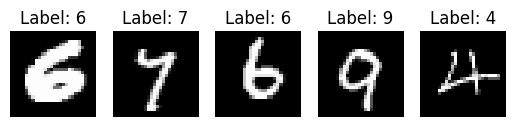

In [ ]:
fig, axes = plt.subplots(1, 5)
for i, (img, label) in enumerate([train_ds[j] for j in range(5)]):
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')
plt.show()

In [ ]:
train_ds[0][0].shape

torch.Size([1, 28, 28])

Dane są już w popranym formacie (N, C, H, W) dla PyTorch. Jest 1 kanał koloru, a samo zdjęcie ma 28x28 piksele.

In [ ]:
x, y = next(iter(train_loader))
print(type(y))
print(y.dtype) # Jest LongTensor tym razem :D
print(y.shape)
print(type(x))
print(x.dtype)
print(x.shape)

<class 'torch.Tensor'>
torch.int64
torch.Size([64])
<class 'torch.Tensor'>
torch.float32
torch.Size([64, 1, 28, 28])


# Funkcje pomocnicze

Model będę testował względem accuracy, żeby patrzeć jak dobrze model dopasowuje liczby. Będę też monitorował val_loss aby określić kiedy model przetrenowuje się.

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, save_path):
    model = model.to(device)
    best_score = None
    best_model_wts = copy.deepcopy(model.state_dict())

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(1, epochs + 1):
        # formazione
        model.train()
        running_loss, running_corrects, total = 0.0, 0, 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)
            preds = outputs.argmax(dim=1)
            running_corrects += (preds == y).sum().item()
            total += y.size(0)

        epoch_train_loss = running_loss / total
        epoch_train_acc = running_corrects / total

        # convalida
        model.eval()
        val_loss, val_corrects, val_total = 0.0, 0, 0

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)

                outputs = model(x)
                loss = criterion(outputs, y)

                val_loss += loss.item() * x.size(0)
                preds = outputs.argmax(dim=1)
                val_corrects += (preds == y).sum().item()
                val_total += y.size(0)

        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_corrects / val_total

        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)

        print(f'Epoch {epoch}/{epochs}|'
              f'Train loss: {epoch_train_loss:.4f}, Train accuracy: {epoch_train_acc:.4f}|'
              f'Val loss: {epoch_val_loss:.4f}, Val accuracy: {epoch_val_acc:.4f}')

        if best_score is None or epoch_val_acc > best_score:
            best_score = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, save_path)
    model.load_state_dict(best_model_wts)
    return history, model


In [ ]:
def test_model(model, test_loader, criterion):
    model = model.to(device)
    model.eval()
    test_loss, test_corrects, test_total = 0.0, 0, 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            outputs = model(x)
            loss = criterion(outputs, y)

            test_loss += loss.item() * x.size(0)
            preds = outputs.argmax(dim=1)
            test_corrects += (preds == y).sum().item()
            test_total += y.size(0)
    print(f'Accuracy: {test_corrects / test_total:.4f}|'
          f'Loss: {test_loss / test_total:.4f}')

Może zrobic funkcje run epoch

# Sieć MLP - baseline

Baselinem będzie prosta sieć MLP, która na wejściu przyjmuje spłaszczony obraz 28x28 i ma dwie warstwy liniowe 256 i 128. Na wyjściu będzie 10 klas.

In [ ]:
class MyMLP(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super(MyMLP, self).__init__(*args, **kwargs)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self. relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [ ]:
model_mlp = MyMLP().to(device)
model_mlp

MyMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.001)

In [ ]:
epochs_mlp = 10
history, model_mlp = train_model(model_mlp, train_loader, val_loader, criterion, optimizer, epochs_mlp, 'model_mlp.pt')

Epoch 1/10|Train loss: 0.2172, Train accuracy: 0.9347|Val loss: 0.1439, Val accuracy: 0.9574
Epoch 2/10|Train loss: 0.1043, Train accuracy: 0.9681|Val loss: 0.1306, Val accuracy: 0.9600
Epoch 3/10|Train loss: 0.0788, Train accuracy: 0.9756|Val loss: 0.0970, Val accuracy: 0.9724
Epoch 4/10|Train loss: 0.0675, Train accuracy: 0.9787|Val loss: 0.1113, Val accuracy: 0.9678
Epoch 5/10|Train loss: 0.0568, Train accuracy: 0.9827|Val loss: 0.1049, Val accuracy: 0.9726
Epoch 6/10|Train loss: 0.0521, Train accuracy: 0.9836|Val loss: 0.1053, Val accuracy: 0.9736
Epoch 7/10|Train loss: 0.0432, Train accuracy: 0.9865|Val loss: 0.1276, Val accuracy: 0.9706
Epoch 8/10|Train loss: 0.0428, Train accuracy: 0.9865|Val loss: 0.1089, Val accuracy: 0.9736
Epoch 9/10|Train loss: 0.0427, Train accuracy: 0.9866|Val loss: 0.1163, Val accuracy: 0.9734
Epoch 10/10|Train loss: 0.0405, Train accuracy: 0.9880|Val loss: 0.1308, Val accuracy: 0.9676


In [ ]:
def show_history(history):
    # Loss
    plt.figure(figsize=(6,6))
    plt.plot(history['train_loss'], label='Train loss')
    plt.plot(history['val_loss'], label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure(figsize=(6,6))
    plt.plot(history['train_acc'], label='Train acc')
    plt.plot(history['val_acc'], label='Val acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [ ]:
test_model(model_mlp, test_loader, criterion)

Accuracy: 0.9739|Loss: 0.1073


97.39% jest całkiem niezłe. Dodatkowo loss jest również dosyć niskie co oznacza, że model nie jest przetrenowany.

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


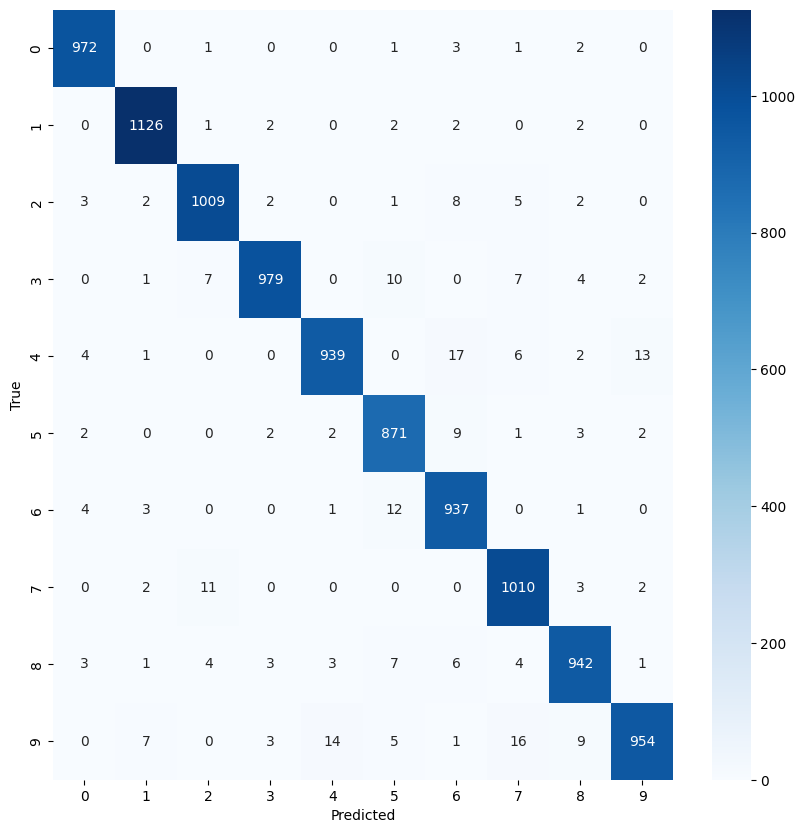

In [ ]:
import seaborn as sns

def plot_confusion_matrix(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(model_mlp, test_loader)

MLP najczesciej myli cyfry 4 i 7 z 9, 2 z 7, 6 z 4 i 5 z 3. Pomylki wydaja się być naturalne, tzn. wydaje się, że człowiek jak już to podobnie się myli.

# CNN - podstawowy

In [ ]:
class MyCNN(nn.Module):
    def __init__(self, *args, **kwargs):
        super(MyCNN, self).__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
model_cnn = MyCNN().to(device)
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)
history, model_cnn = train_model(model_cnn, train_loader, val_loader, criterion, optimizer, epochs, 'model_cnn.pt')

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/10|Train loss: 0.1329, Train accuracy: 0.9584|Val loss: 0.0581, Val accuracy: 0.9842
Epoch 2/10|Train loss: 0.0467, Train accuracy: 0.9861|Val loss: 0.0653, Val accuracy: 0.9796
Epoch 3/10|Train loss: 0.0322, Train accuracy: 0.9898|Val loss: 0.0458, Val accuracy: 0.9866
Epoch 4/10|Train loss: 0.0244, Train accuracy: 0.9921|Val loss: 0.0506, Val accuracy: 0.9868
Epoch 5/10|Train loss: 0.0189, Train accuracy: 0.9942|Val loss: 0.0343, Val accuracy: 0.9900
Epoch 6/10|Train loss: 0.0177, Train accuracy: 0.9941|Val loss: 0.0459, Val accuracy: 0.9860
Epoch 7/10|Train loss: 0.0138, Train accuracy: 0.9954|Val loss: 0.0637, Val accuracy: 0.9866
Epoch 8/10|Train loss: 0.0117, Train accuracy: 0.9957|Val loss: 0.0483, Val accuracy: 0.9896
Epoch 9/10|Train loss: 0.0122, Train accuracy: 0.9961|Val loss: 0.0651, Val accuracy: 0.9858
Epoch 10/10|Train loss: 0.0115, Train accuracy: 0.9962|Val loss: 0.0513, Val accuracy: 0.9888


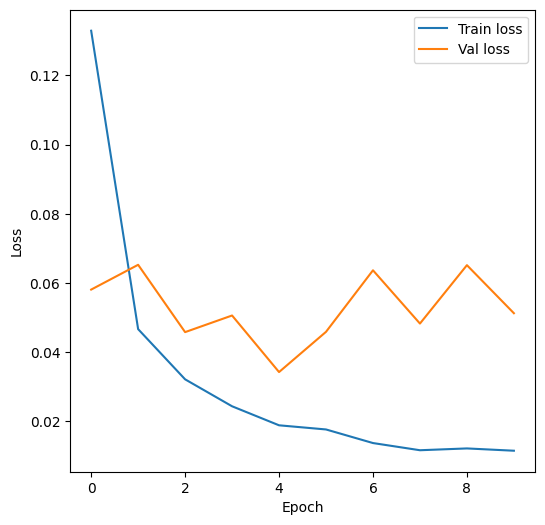

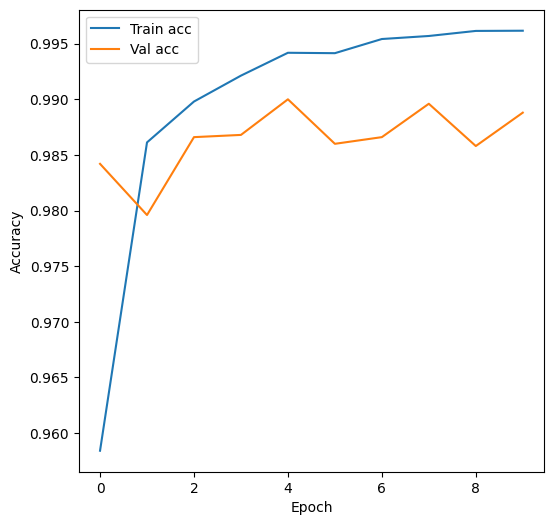

In [ ]:
show_history(history)

In [ ]:
test_model(model_cnn, test_loader, criterion)

Accuracy: 0.9899|Loss: 0.0358


Zaletą CNN jest to, że uczy się szybciej od zwykłych sieci MLP. Praktycznie od razu ma wysokie accuracy przy jeszcze niższej wartości funkcji straty. CNN można trenować szybciej i osiągać wyższą skuteczność.

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


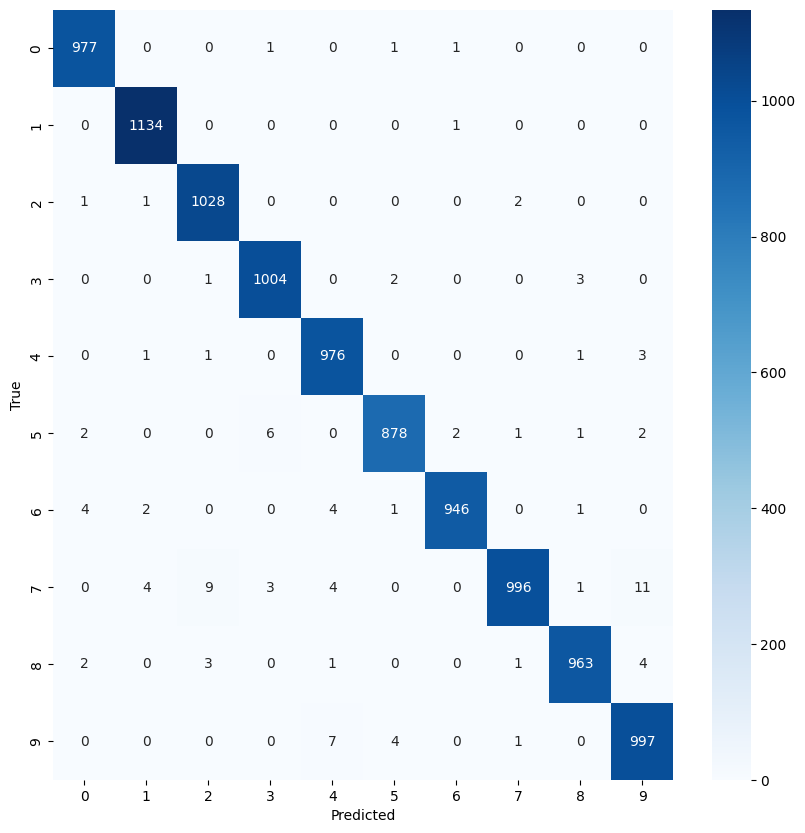

In [ ]:
plot_confusion_matrix(model_cnn, test_loader)

Najczęściej CNN myli 2 i 9 z 7, co również wydaje się naturalne. Widać jednak, że lepiej sobie radzi z innymi liczbami.

# Dodanie BatchNorm i Dropout

Dzięki Batch Normalization uczenie powinno przebiegać szybciej i stabilniej. Ta warstwa normalizuje wyjscia z poprzedniej warstwy dla kazdego batcha.

Dzieki Dropoutowi można zapobiec przeuczeniu się. Ta funkcja wyłącza pewien określony preocent neuronów podczas treningu. Sprawia, że sieć uczy się bardziej uniwersalnie nie polegając w wiekszym stopniu na np. jednym neuronie o wysokiej wadze.

In [ ]:
class MyCNNv2(nn.Module):
    def __init__(self, *args, **kwargs):
        super(MyCNNv2, self).__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout(0.2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*7*7, 128)
        self.dropout3 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

In [ ]:
model_cnn_v2 = MyCNNv2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn_v2.parameters(), lr=0.001)
history, model_cnn_v2 = train_model(model_cnn_v2, train_loader, val_loader, criterion, optimizer, epochs, 'model_cnn_v2.pt')

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/10|Train loss: 0.2137, Train accuracy: 0.9336|Val loss: 0.0677, Val accuracy: 0.9800
Epoch 2/10|Train loss: 0.0895, Train accuracy: 0.9729|Val loss: 0.0494, Val accuracy: 0.9868
Epoch 3/10|Train loss: 0.0683, Train accuracy: 0.9792|Val loss: 0.0479, Val accuracy: 0.9880
Epoch 4/10|Train loss: 0.0590, Train accuracy: 0.9818|Val loss: 0.0419, Val accuracy: 0.9878
Epoch 5/10|Train loss: 0.0513, Train accuracy: 0.9837|Val loss: 0.0368, Val accuracy: 0.9898
Epoch 6/10|Train loss: 0.0439, Train accuracy: 0.9859|Val loss: 0.0364, Val accuracy: 0.9890
Epoch 7/10|Train loss: 0.0438, Train accuracy: 0.9860|Val loss: 0.0347, Val accuracy: 0.9906
Epoch 8/10|Train loss: 0.0413, Train accuracy: 0.9867|Val loss: 0.0335, Val accuracy: 0.9910
Epoch 9/10|Train loss: 0.0351, Train accuracy: 0.9888|Val loss: 0.0304, Val accuracy: 0.9908
Epoch 10/10|Train loss: 0.0323, Train accuracy: 0.9897|Val loss: 0.0388, Val accuracy: 0.9900


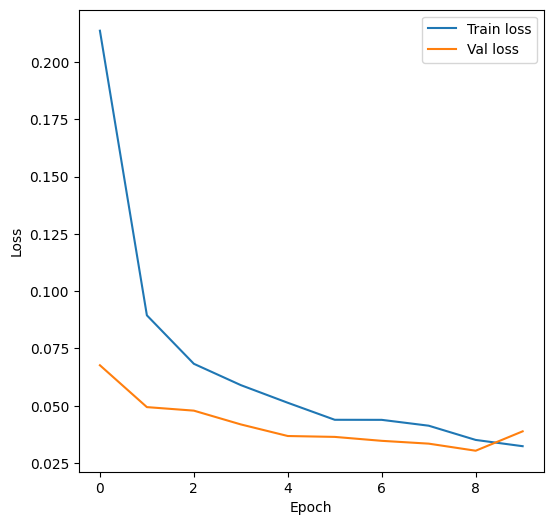

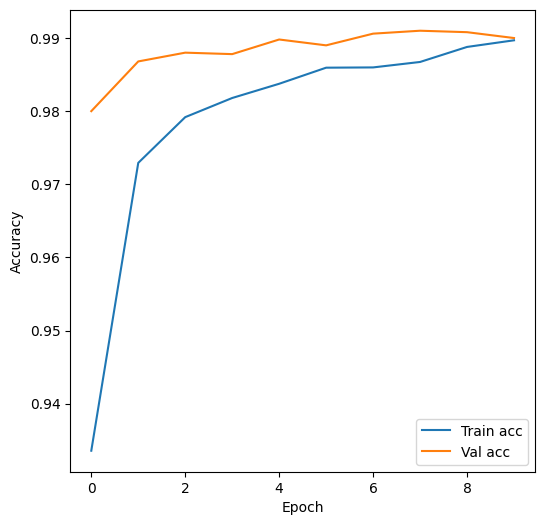

In [ ]:
show_history(history)

In [ ]:
test_model(model_cnn_v2, test_loader, criterion)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy: 0.9922|Loss: 0.0234


Dodanie BatchNorm i Dropoutu poprawia skuteczność sieci, jednak wydłużyło proces uczenia.

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


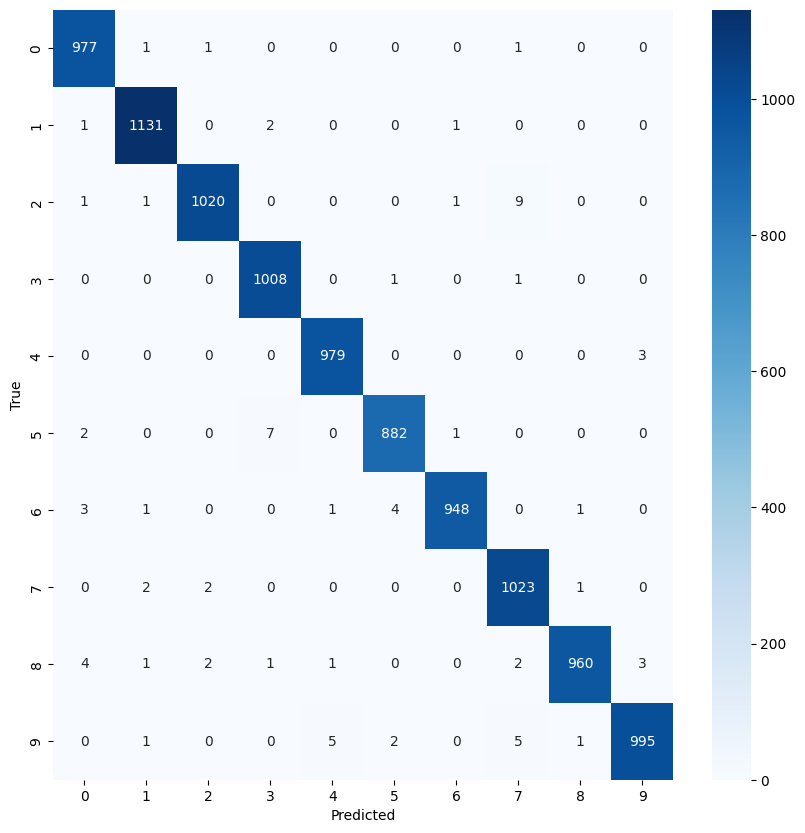

In [ ]:
plot_confusion_matrix(model_cnn_v2, test_loader)

In [ ]:
Dzięki dropoutowi zwiększyła się uniwersalność modelu, który ma mniej pomyłek niż poprzednie. Jednie widać ich sporo przy 2 i 7. Można było się tego spodziewać.

# Zwiększenie dropoutu

In [ ]:
class MyCNNv3(nn.Module):
    def __init__(self, *args, **kwargs):
        super(MyCNNv3, self).__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout(0.33)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*7*7, 128)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

In [ ]:
model_cnn_v3 = MyCNNv3().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn_v3.parameters(), lr=0.001)
history, model_cnn_v3 = train_model(model_cnn_v3, train_loader, val_loader, criterion, optimizer, epochs, 'model_cnn_v3.pt')

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/10|Train loss: 0.3168, Train accuracy: 0.9018|Val loss: 0.0797, Val accuracy: 0.9762
Epoch 2/10|Train loss: 0.1443, Train accuracy: 0.9553|Val loss: 0.0608, Val accuracy: 0.9810
Epoch 3/10|Train loss: 0.1198, Train accuracy: 0.9638|Val loss: 0.0515, Val accuracy: 0.9856
Epoch 4/10|Train loss: 0.1082, Train accuracy: 0.9670|Val loss: 0.0442, Val accuracy: 0.9868
Epoch 5/10|Train loss: 0.0973, Train accuracy: 0.9704|Val loss: 0.0400, Val accuracy: 0.9874
Epoch 6/10|Train loss: 0.0886, Train accuracy: 0.9731|Val loss: 0.0384, Val accuracy: 0.9880
Epoch 7/10|Train loss: 0.0832, Train accuracy: 0.9742|Val loss: 0.0358, Val accuracy: 0.9890
Epoch 8/10|Train loss: 0.0798, Train accuracy: 0.9756|Val loss: 0.0356, Val accuracy: 0.9890
Epoch 9/10|Train loss: 0.0742, Train accuracy: 0.9781|Val loss: 0.0307, Val accuracy: 0.9904
Epoch 10/10|Train loss: 0.0716, Train accuracy: 0.9779|Val loss: 0.0333, Val accuracy: 0.9910


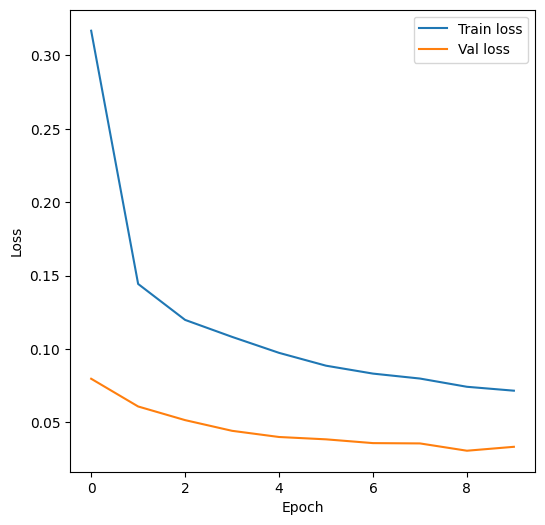

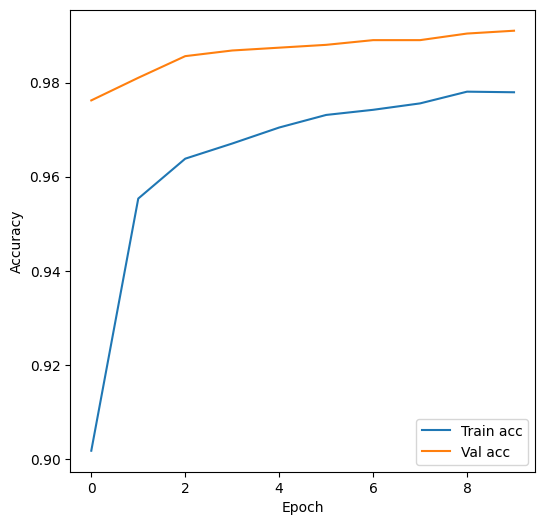

In [ ]:
show_history(history)

In [ ]:
test_model(model_cnn_v3, test_loader, criterion)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy: 0.9912|Loss: 0.0253


W moim przypadku skuteczność spadła dla tych wartości.

# Wnioski

- Dla tak prostych datasetów nawet MLP osiąga wysoką skuteczność (97,39%)

- Wydajność większą uzyskują jednak sieci konwolucyjne (99.2%), dzięki operacji konwolucji. Sprawia ona, że sieć wychwytuje właściwości takie jak linie, kształty i pozwala być znacznie bardziej uniwersalna. Jest znacznie mniej wrażliwa na np. drobne przesunięcia cyfr.

- Dodanie BatchNorm i Dropoutu nieznacznie poprawiło wynik, jednak późniejsze zwiększenie dropoutu go obniżyło

- Najważniejszą metryką jest accuracy

- Model często we wszystkich przypadkach myli 2 z 7 lub 3 z 5.